# Human Pose Classification using GCN

This notebook implements the training pipeline for classifying human poses using Graph Convolutional Networks (GCN).

In [1]:
# Import required libraries
import torch
from torch_geometric.loader import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import os

# Import our modules
import sys
sys.path.append('src')
from data_processing import load_dataset
from gcn_model import PoseGCN

print("All libraries imported successfully!")

All libraries imported successfully!


## Check Data Paths

In [2]:
# Define and verify data paths
data_dir = os.path.join(os.getcwd(), 'data_v1')
annotation_dir = os.path.join(os.getcwd(), 'annotations_v1')

# Check if directories exist
print(f"Checking data directory: {data_dir}")
print(f"Exists: {os.path.exists(data_dir)}")

print(f"\nChecking annotation directory: {annotation_dir}")
print(f"Exists: {os.path.exists(annotation_dir)}")

# Check annotation files
annotation_files = [
    'correct_n2_3_7_100.json',
    'lumbar_3_7_dell_111.json'
]

print("\nChecking annotation files:")
for file in annotation_files:
    file_path = os.path.join(annotation_dir, file)
    print(f"{file}: {'Exists' if os.path.exists(file_path) else 'Missing'}")

Checking data directory: c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\data_v1
Exists: True

Checking annotation directory: c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\annotations_v1
Exists: True

Checking annotation files:
correct_n2_3_7_100.json: Exists
lumbar_3_7_dell_111.json: Exists


## Define Training and Evaluation Functions

In [3]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for data in tqdm(train_loader, desc='Training', leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, data.y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [4]:
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            pred = output.max(dim=1)[1]
            
            predictions.extend(pred.cpu().numpy())
            labels.extend(data.y.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return accuracy, precision, recall, f1

In [5]:
def plot_metrics(train_losses, val_metrics):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot training loss
    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    
    # Plot validation metrics
    epochs = range(len(val_metrics['accuracy']))
    ax2.plot(epochs, val_metrics['accuracy'], 'g-', label='Accuracy')
    ax2.plot(epochs, val_metrics['precision'], 'r-', label='Precision')
    ax2.plot(epochs, val_metrics['recall'], 'b-', label='Recall')
    ax2.plot(epochs, val_metrics['f1'], 'y-', label='F1-Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Setup Training

In [6]:
try:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load datasets using absolute paths
    train_dataset, val_dataset = load_dataset(
        root_dir=data_dir,
        annotation_dir=annotation_dir
    )

    print(f"Dataset loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = PoseGCN(num_node_features=2).to(device)  # 2 features: x, y coordinates
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Model and optimizer initialized!")
    
except Exception as e:
    print(f"Error during setup: {str(e)}")
    raise

Using device: cpu
Loading annotations from c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\annotations_v1
Successfully loaded c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\annotations_v1\correct_n2_3_7_100.json
Loaded 102 poses from c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\annotations_v1\correct_n2_3_7_100.json
Successfully loaded c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\annotations_v1\lumbar_3_7_dell_111.json
Loaded 108 poses from c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\annotations_v1\lumbar_3_7_dell_111.json
Loaded 102 correct poses and 108 incorrect poses
Sample correct pose data: [[335.15, 109.75, 2], [336.81, 92.59, 2]]
Sample incorrect pose data: [[333.78, 89.31, 2], [323.94, 67.25, 2]]
Dataset loaded: 168 training samples, 42 validation samples
Model and optimizer initialized!


## Training Loop

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 001:
Train Loss: 0.6960
Val Accuracy: 0.5238, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
New best model saved! Accuracy: 0.5238


c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 002:
Train Loss: 0.6979
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 003:
Train Loss: 0.6987
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 004:
Train Loss: 0.6922
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 005:
Train Loss: 0.6922
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


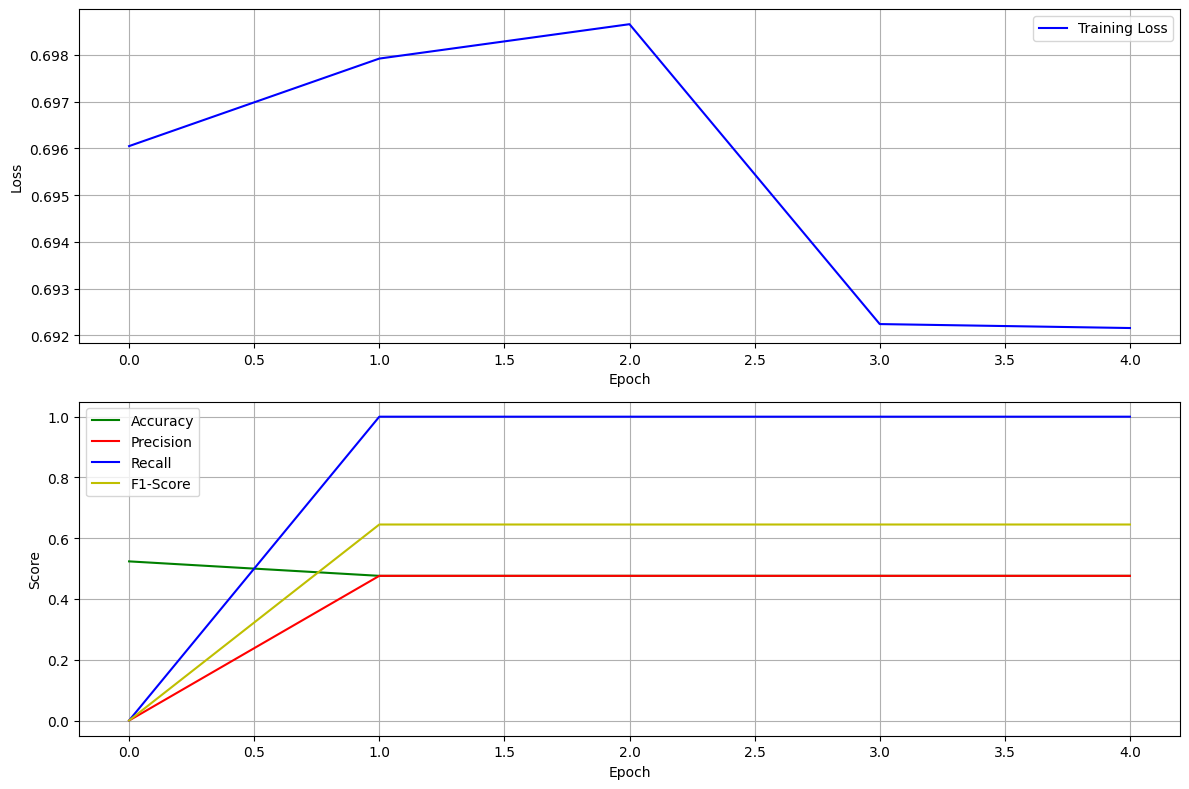

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 006:
Train Loss: 0.6919
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 007:
Train Loss: 0.6973
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 008:
Train Loss: 0.6927
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 009:
Train Loss: 0.6912
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 010:
Train Loss: 0.6928
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


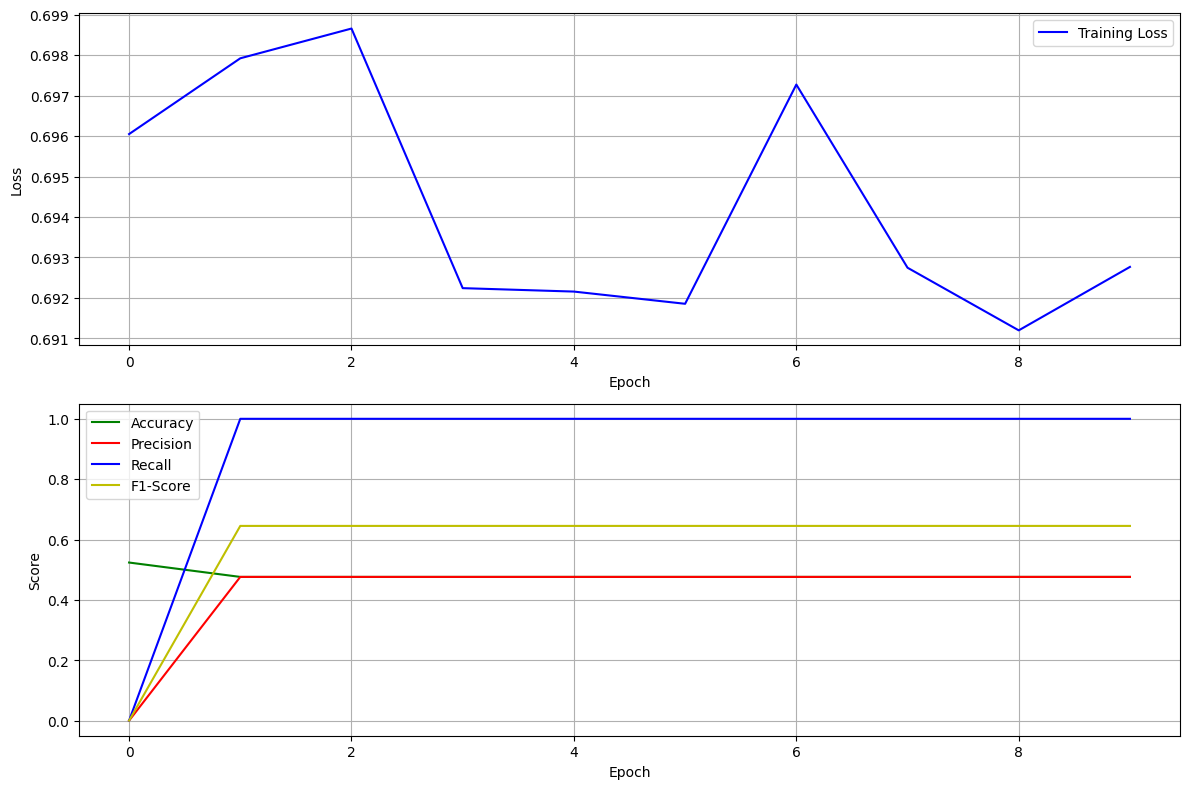

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 011:
Train Loss: 0.6894
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 012:
Train Loss: 0.6916
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 013:
Train Loss: 0.6871
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 014:
Train Loss: 0.6922
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 015:
Train Loss: 0.6929
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


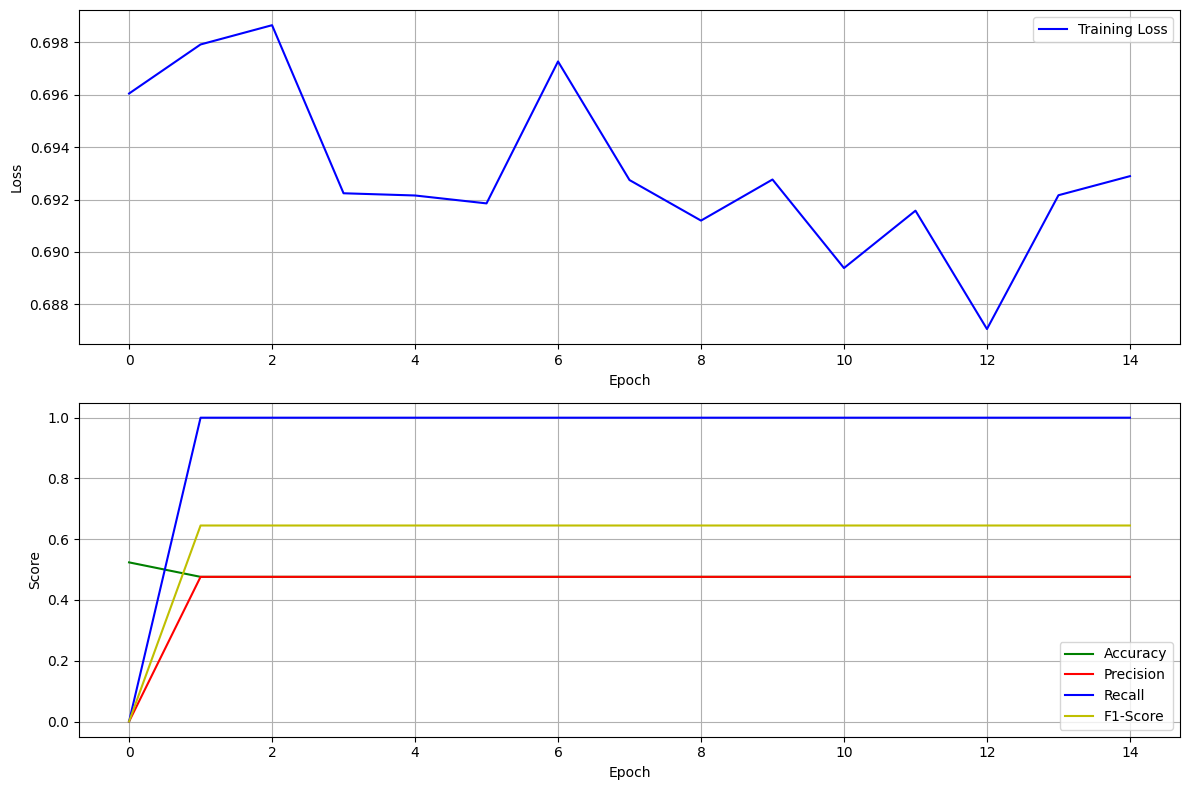

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 016:
Train Loss: 0.6802
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 017:
Train Loss: 0.6932
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 018:
Train Loss: 0.6900
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 019:
Train Loss: 0.6939
Val Accuracy: 0.5238, Precision: 0.5000, Recall: 0.4500, F1: 0.4737


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 020:
Train Loss: 0.6866
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706
New best model saved! Accuracy: 0.5714


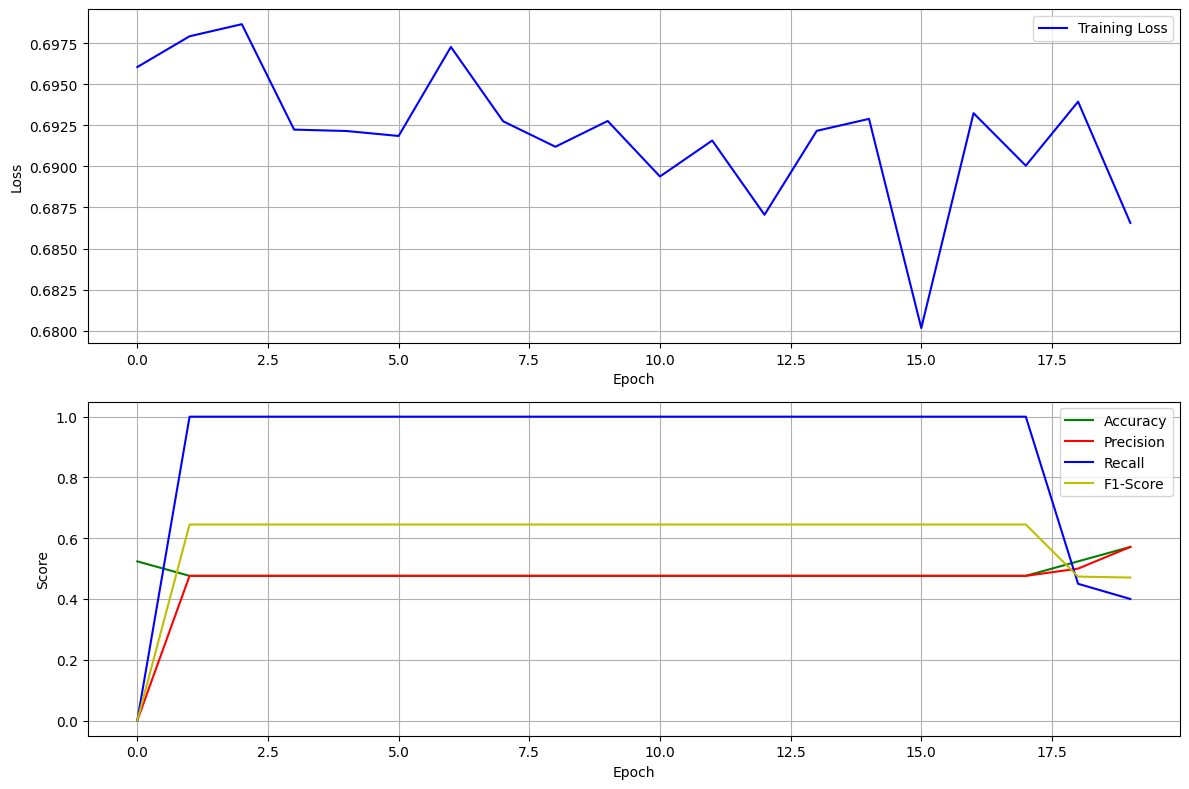

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 021:
Train Loss: 0.6873
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 022:
Train Loss: 0.6828
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 023:
Train Loss: 0.6782
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 024:
Train Loss: 0.6940
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 025:
Train Loss: 0.6874
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


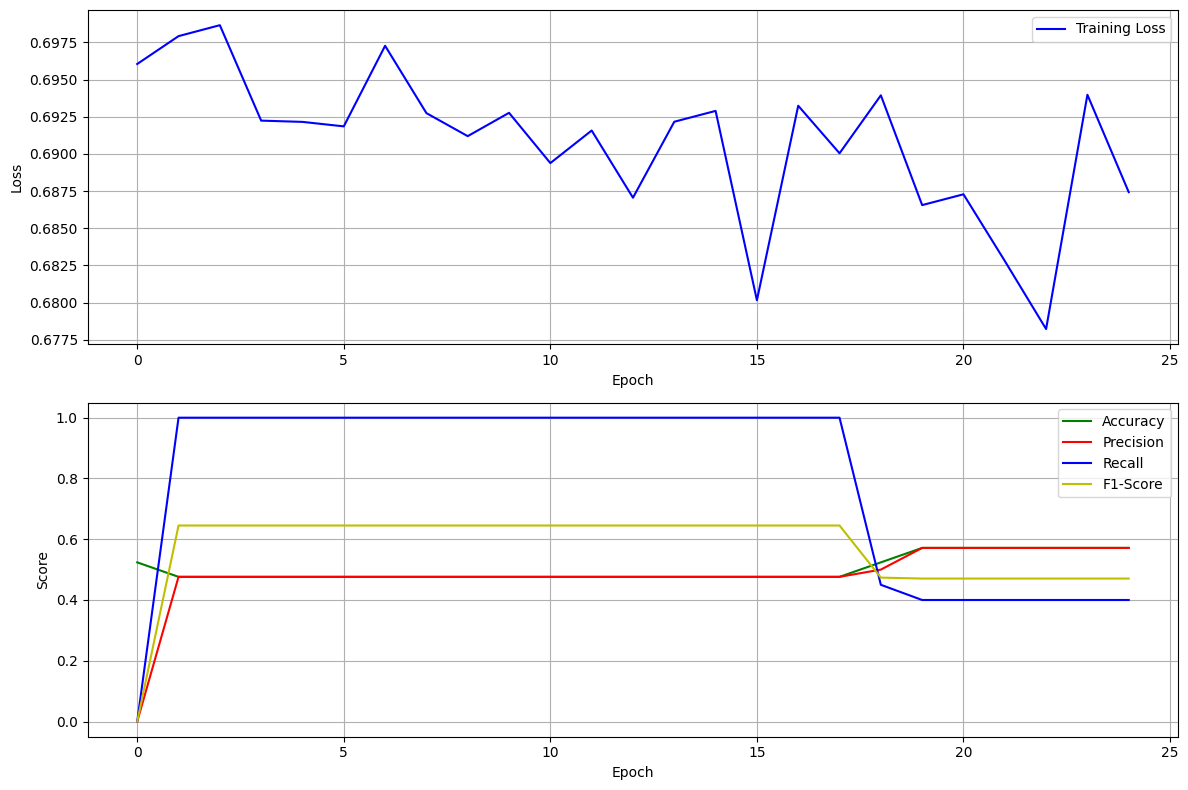

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 026:
Train Loss: 0.6830
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 027:
Train Loss: 0.6796
Val Accuracy: 0.5000, Precision: 0.4706, Recall: 0.4000, F1: 0.4324


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 028:
Train Loss: 0.6826
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 029:
Train Loss: 0.6845
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 030:
Train Loss: 0.6855
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


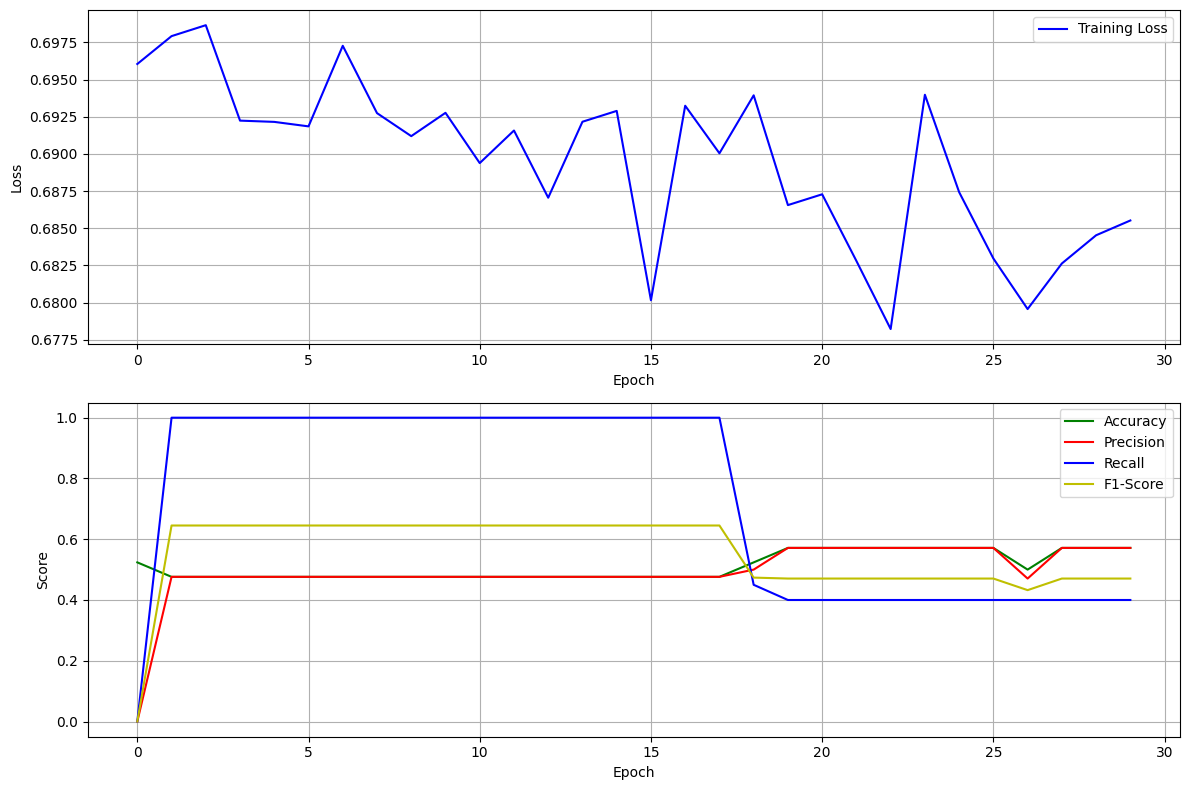

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 031:
Train Loss: 0.6847
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 032:
Train Loss: 0.6808
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 033:
Train Loss: 0.7009
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 034:
Train Loss: 0.6967
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 035:
Train Loss: 0.6766
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


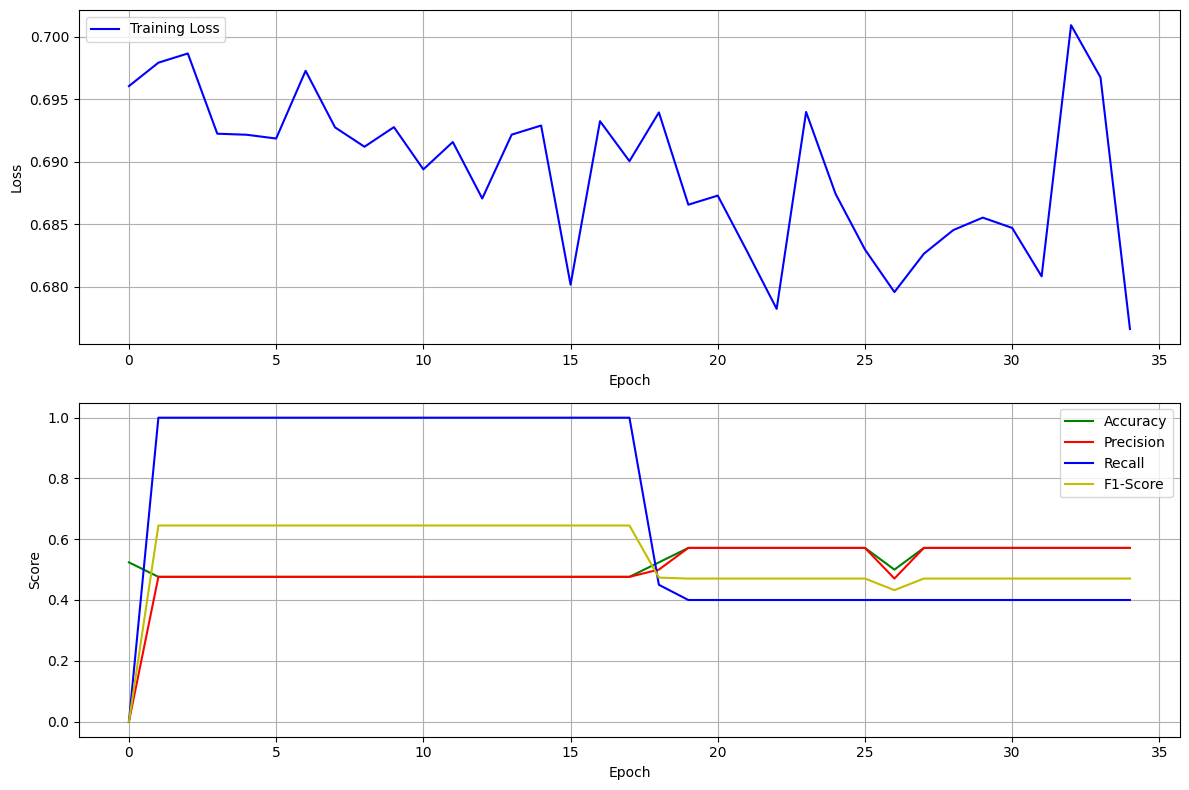

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 036:
Train Loss: 0.6867
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 037:
Train Loss: 0.6867
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 038:
Train Loss: 0.6925
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 039:
Train Loss: 0.6826
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 040:
Train Loss: 0.6823
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


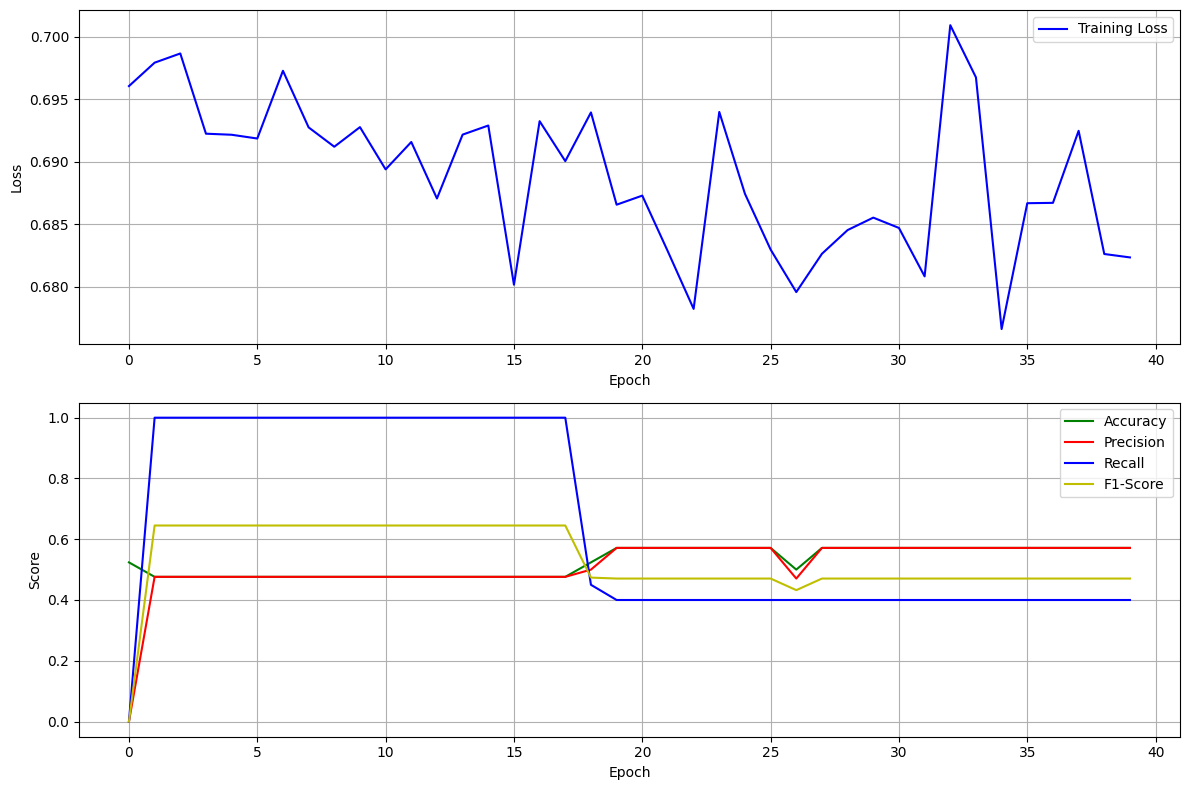

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 041:
Train Loss: 0.6701
Val Accuracy: 0.5714, Precision: 0.5625, Recall: 0.4500, F1: 0.5000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 042:
Train Loss: 0.6828
Val Accuracy: 0.5238, Precision: 0.5000, Recall: 0.5000, F1: 0.5000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 043:
Train Loss: 0.6813
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 044:
Train Loss: 0.6857
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 045:
Train Loss: 0.6834
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


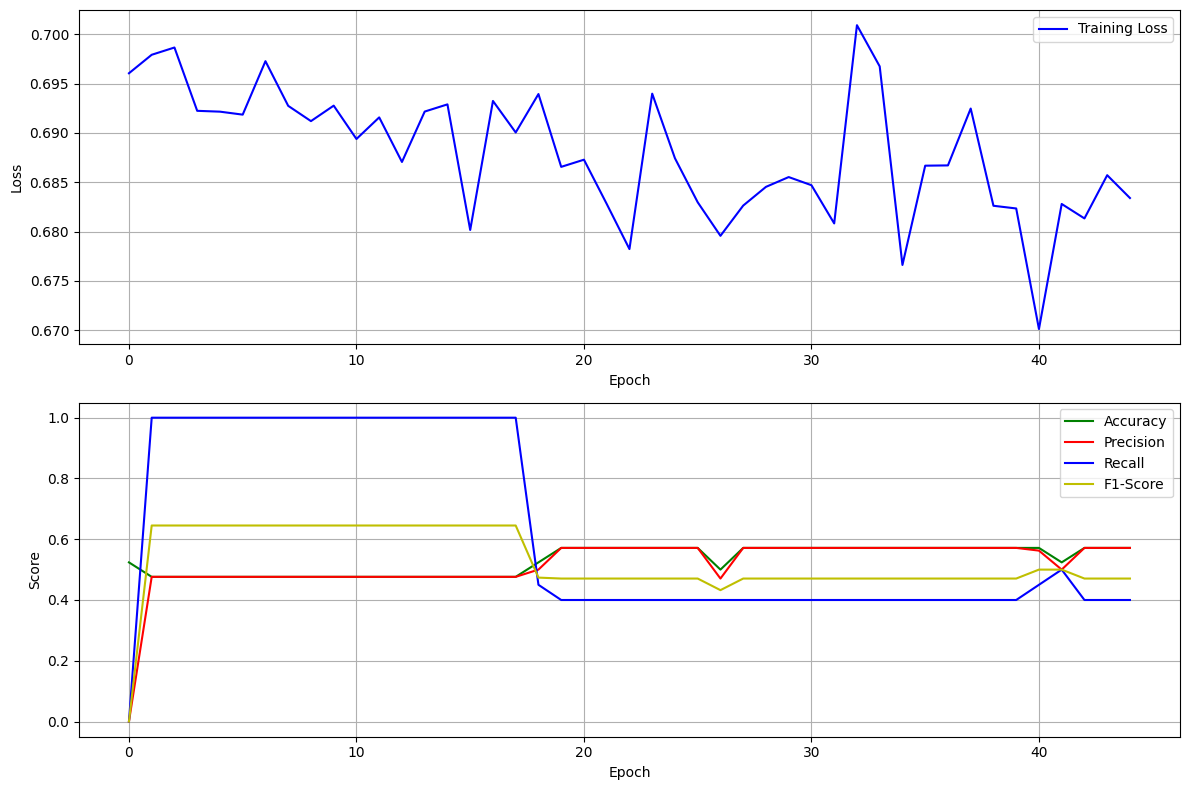

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 046:
Train Loss: 0.6772
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 047:
Train Loss: 0.6948
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 048:
Train Loss: 0.6883
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 049:
Train Loss: 0.6967
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 050:
Train Loss: 0.6918
Val Accuracy: 0.5476, Precision: 0.5385, Recall: 0.3500, F1: 0.4242


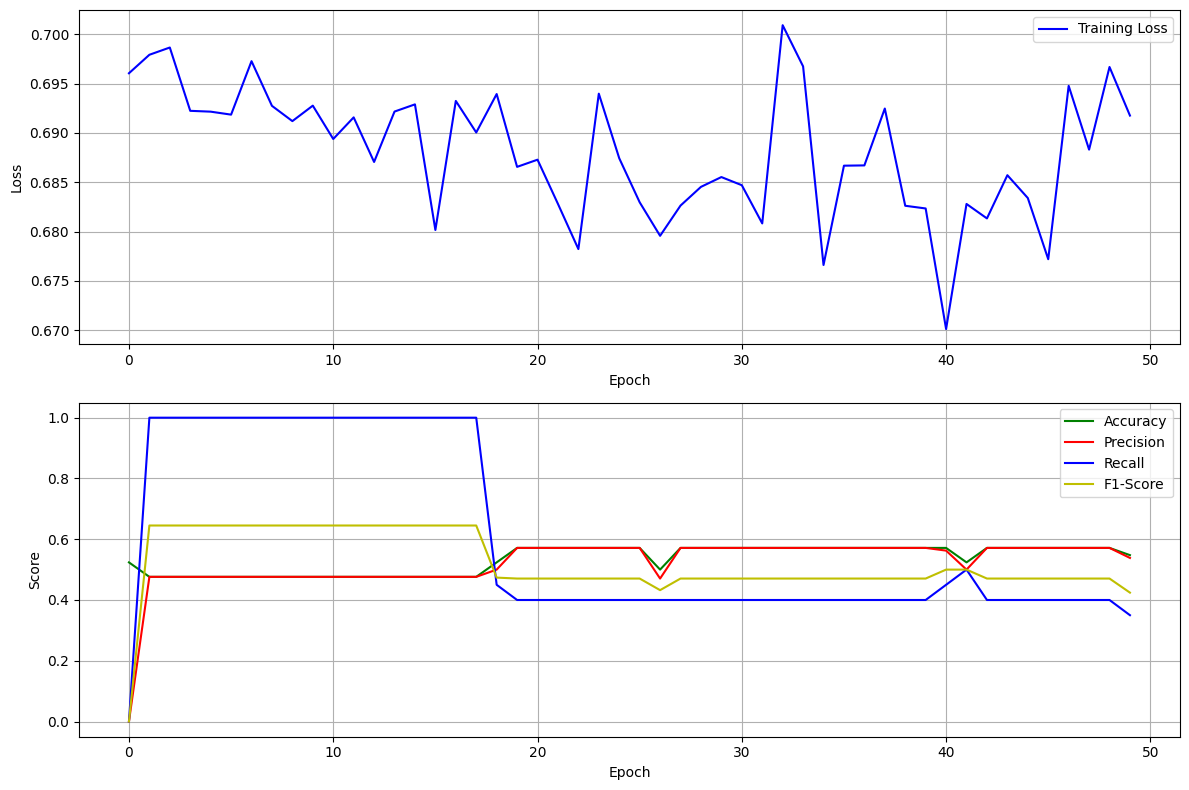

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 051:
Train Loss: 0.6817
Val Accuracy: 0.5476, Precision: 0.5385, Recall: 0.3500, F1: 0.4242


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 052:
Train Loss: 0.6819
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 053:
Train Loss: 0.6838
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 054:
Train Loss: 0.6909
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 055:
Train Loss: 0.6882
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


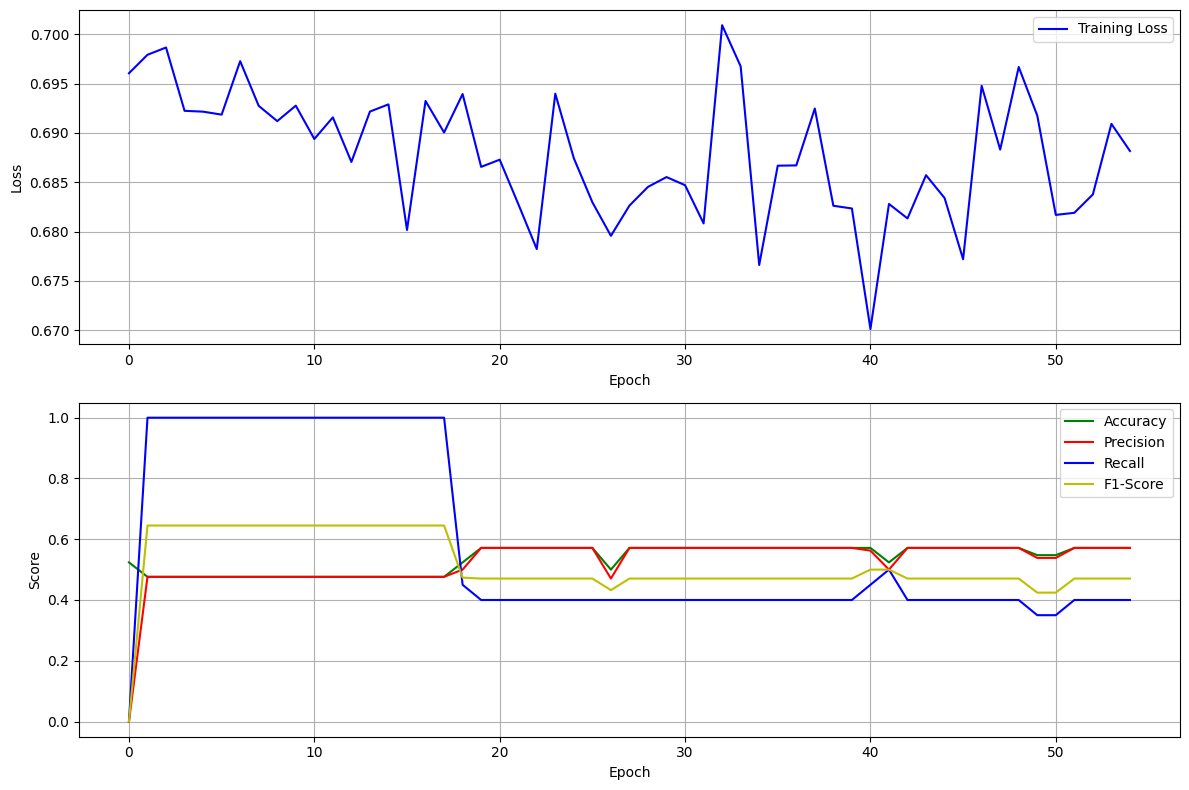

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 056:
Train Loss: 0.6846
Val Accuracy: 0.5238, Precision: 0.5000, Recall: 0.5000, F1: 0.5000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 057:
Train Loss: 0.6822
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 058:
Train Loss: 0.6794
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 059:
Train Loss: 0.6792
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 060:
Train Loss: 0.6885
Val Accuracy: 0.5238, Precision: 0.5000, Recall: 0.5000, F1: 0.5000


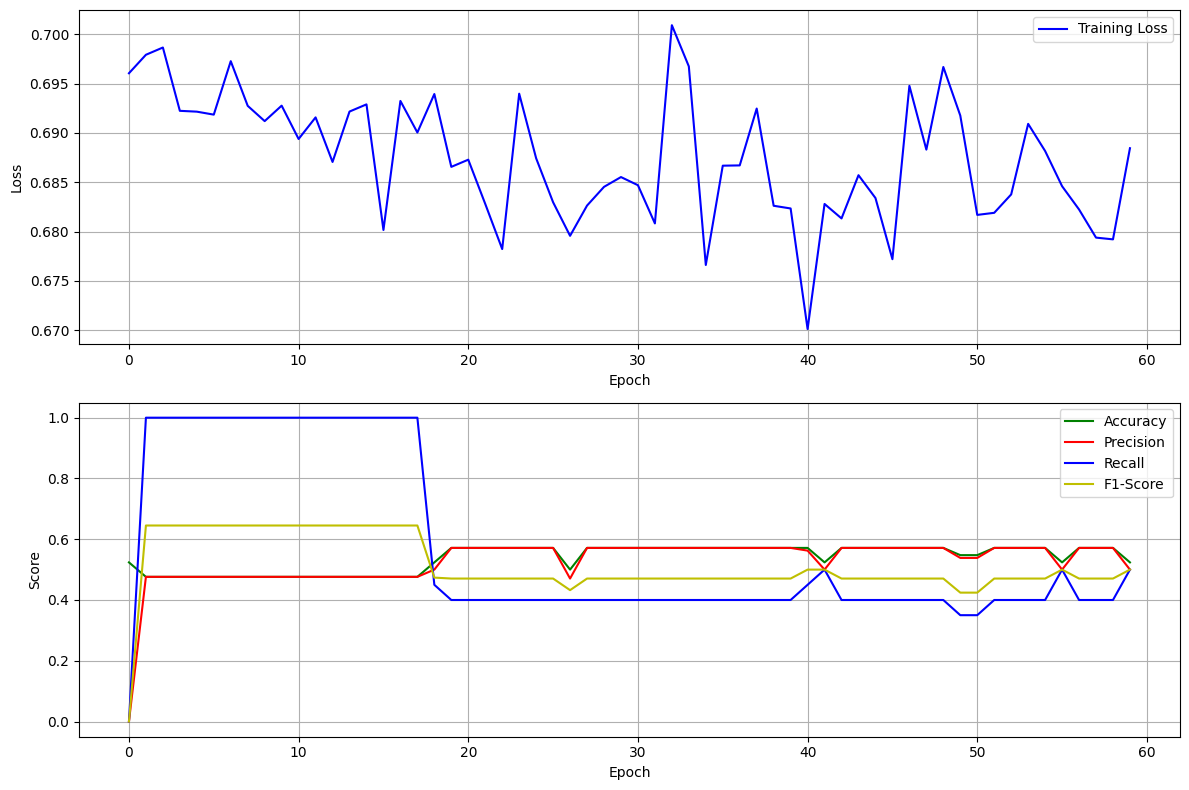

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 061:
Train Loss: 0.6885
Val Accuracy: 0.5238, Precision: 0.5000, Recall: 0.5000, F1: 0.5000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 062:
Train Loss: 0.6846
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 063:
Train Loss: 0.6826
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 064:
Train Loss: 0.6729
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 065:
Train Loss: 0.6730
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


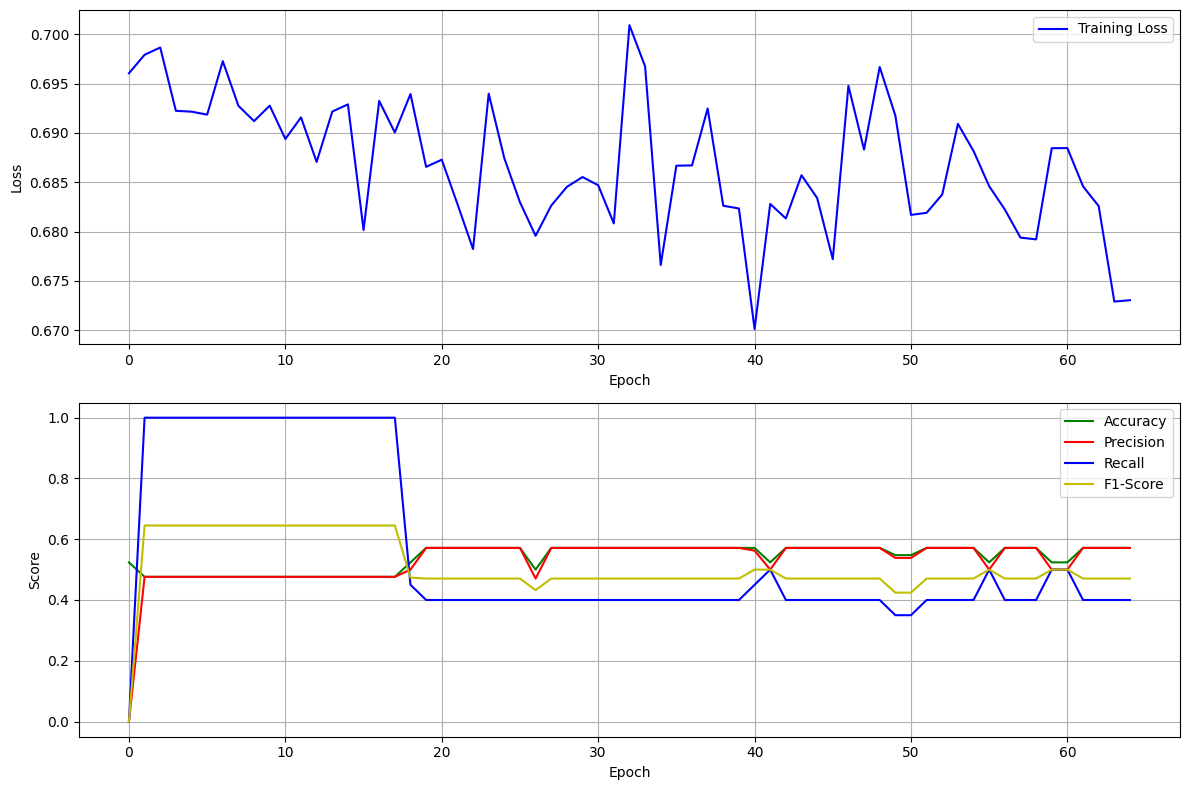

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 066:
Train Loss: 0.6899
Val Accuracy: 0.5238, Precision: 0.5000, Recall: 0.5000, F1: 0.5000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 067:
Train Loss: 0.6946
Val Accuracy: 0.5714, Precision: 0.5625, Recall: 0.4500, F1: 0.5000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 068:
Train Loss: 0.6794
Val Accuracy: 0.5952, Precision: 0.6000, Recall: 0.4500, F1: 0.5143
New best model saved! Accuracy: 0.5952


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 069:
Train Loss: 0.6782
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 070:
Train Loss: 0.6926
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


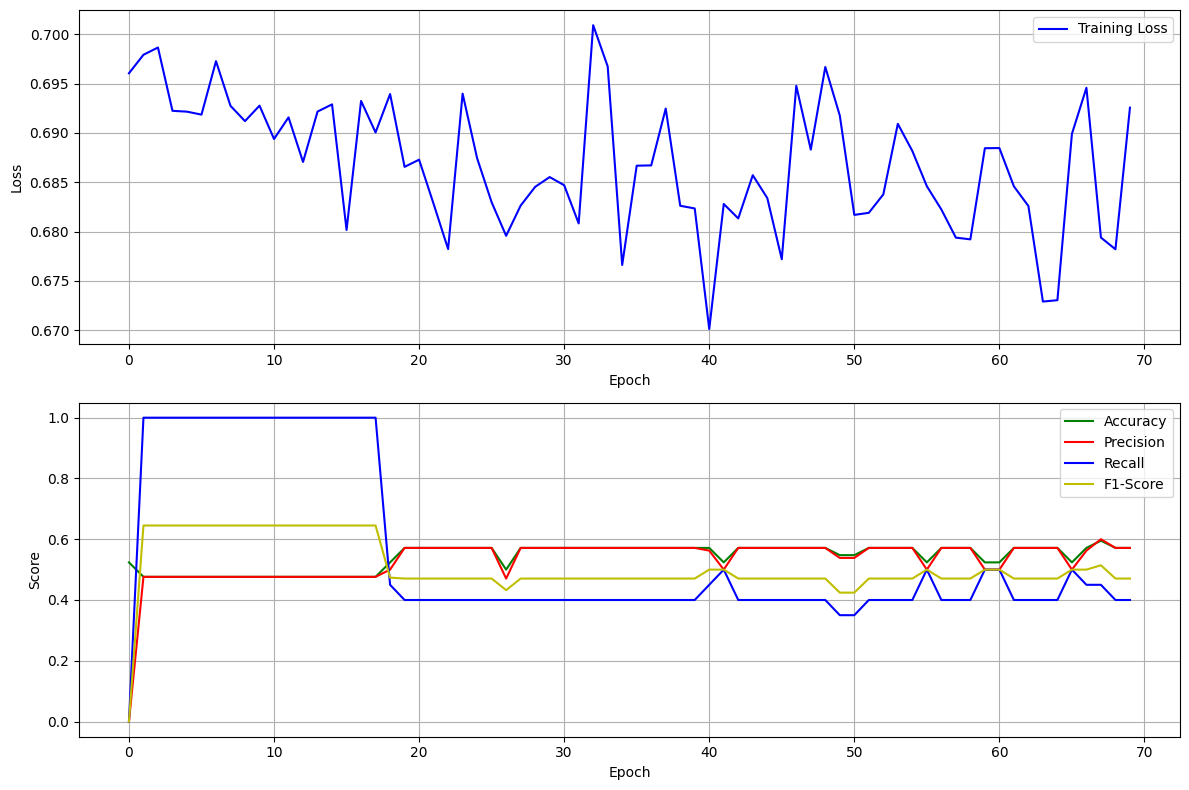

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 071:
Train Loss: 0.6945
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 072:
Train Loss: 0.6800
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 073:
Train Loss: 0.6653
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 074:
Train Loss: 0.6660
Val Accuracy: 0.6429, Precision: 0.6000, Recall: 0.7500, F1: 0.6667
New best model saved! Accuracy: 0.6429


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 075:
Train Loss: 0.6878
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


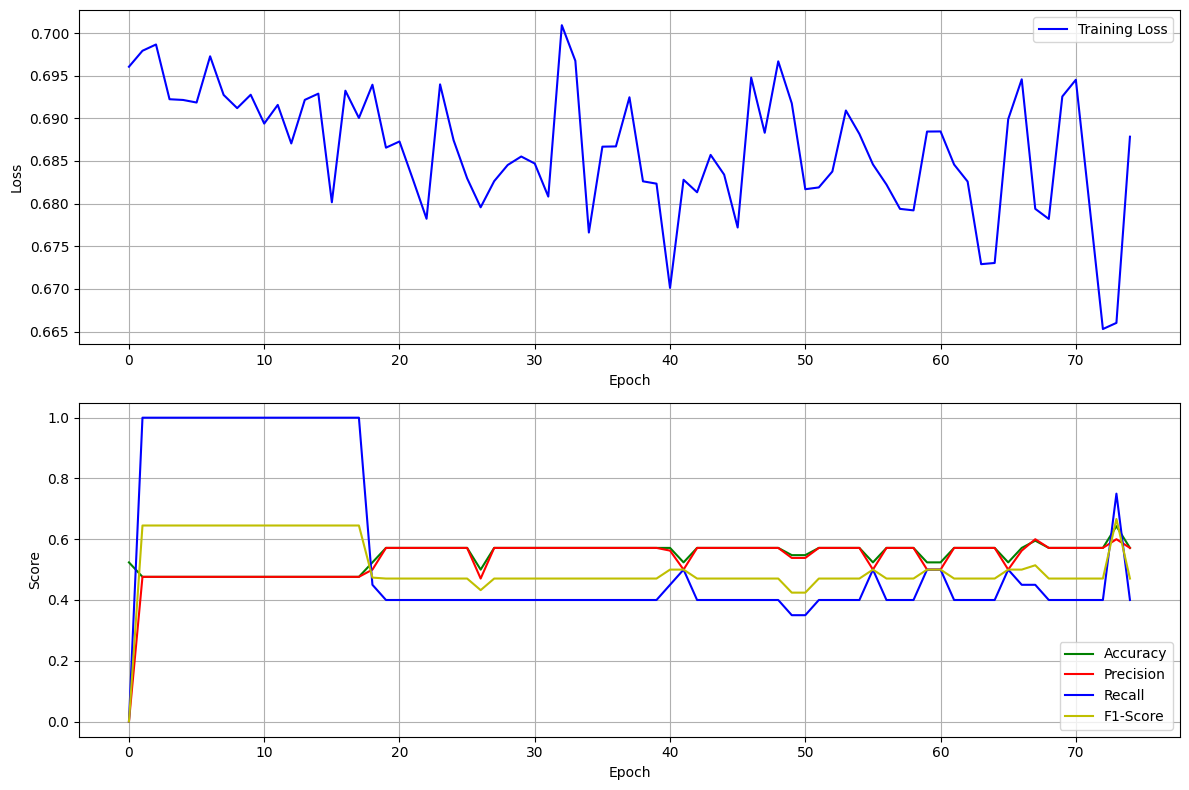

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 076:
Train Loss: 0.6633
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 077:
Train Loss: 0.6772
Val Accuracy: 0.6429, Precision: 0.6000, Recall: 0.7500, F1: 0.6667


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 078:
Train Loss: 0.6735
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 079:
Train Loss: 0.6768
Val Accuracy: 0.6190, Precision: 0.6250, Recall: 0.5000, F1: 0.5556


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 080:
Train Loss: 0.6649
Val Accuracy: 0.5952, Precision: 0.6000, Recall: 0.4500, F1: 0.5143


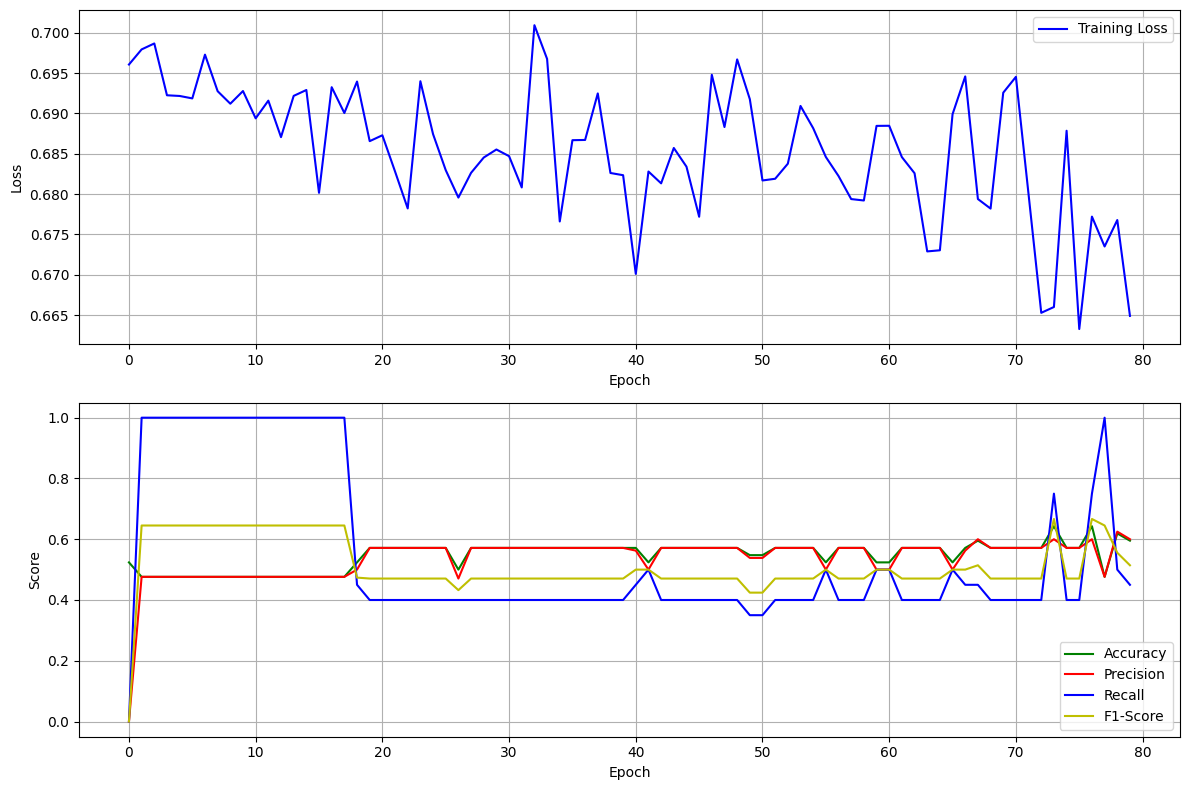

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 081:
Train Loss: 0.6762
Val Accuracy: 0.6667, Precision: 0.6364, Recall: 0.7000, F1: 0.6667
New best model saved! Accuracy: 0.6667


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 082:
Train Loss: 0.6893
Val Accuracy: 0.6190, Precision: 0.6250, Recall: 0.5000, F1: 0.5556


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 083:
Train Loss: 0.6915
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 084:
Train Loss: 0.6651
Val Accuracy: 0.7143, Precision: 0.6667, Recall: 0.8000, F1: 0.7273
New best model saved! Accuracy: 0.7143


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 085:
Train Loss: 0.6913
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


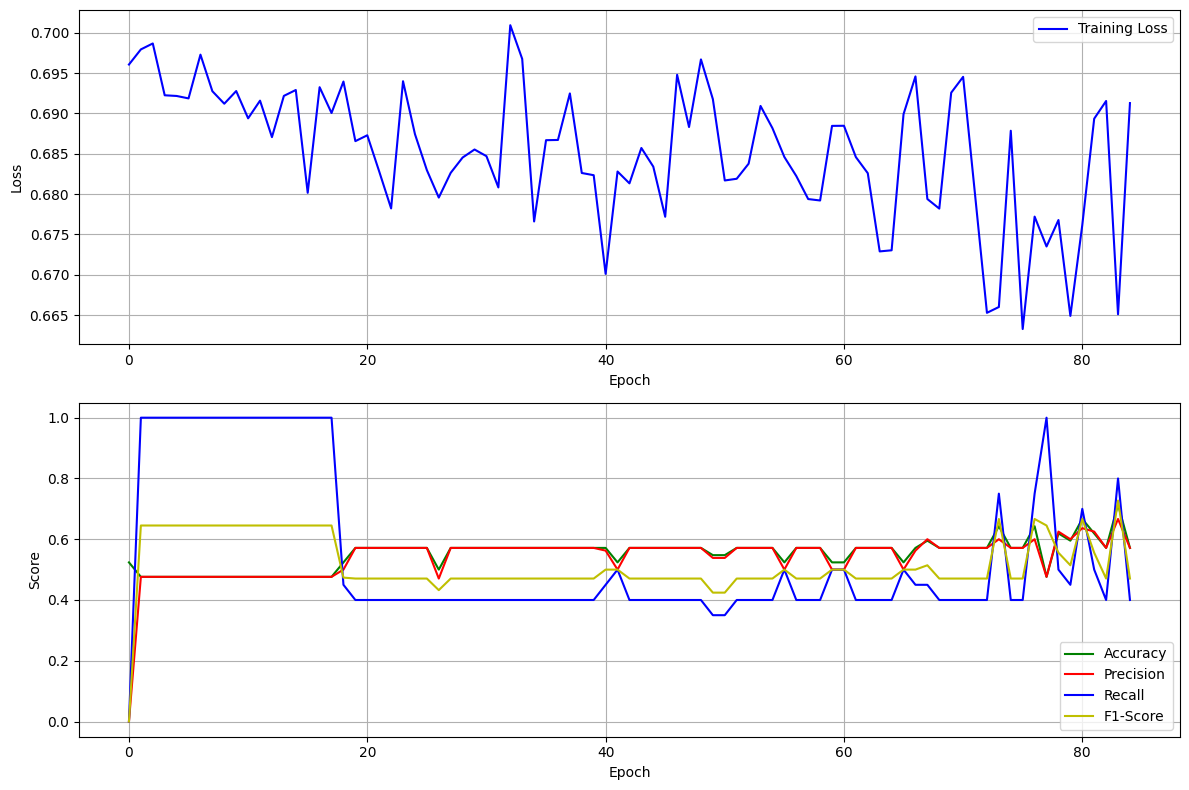

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 086:
Train Loss: 0.6713
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 087:
Train Loss: 0.6797
Val Accuracy: 0.6429, Precision: 0.6471, Recall: 0.5500, F1: 0.5946


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 088:
Train Loss: 0.6653
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 089:
Train Loss: 0.6964
Val Accuracy: 0.4762, Precision: 0.4762, Recall: 1.0000, F1: 0.6452


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 090:
Train Loss: 0.6741
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


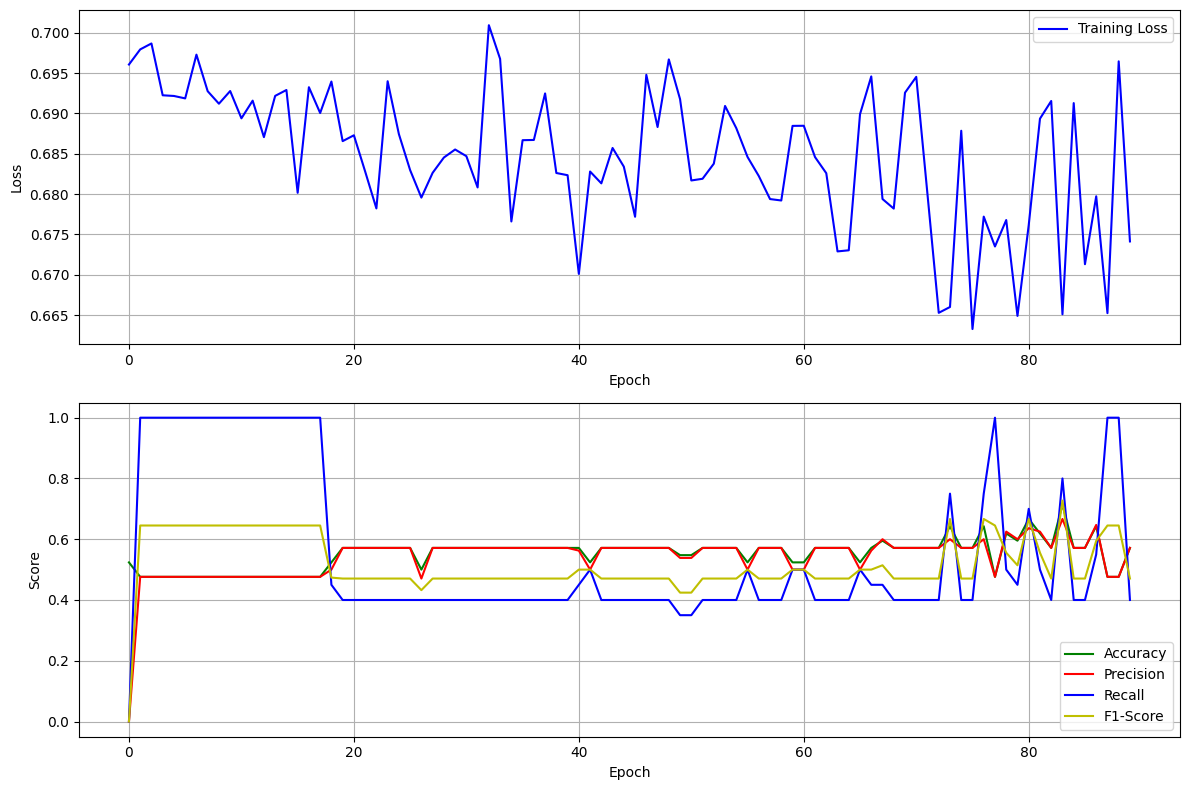

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 091:
Train Loss: 0.6872
Val Accuracy: 0.4762, Precision: 0.4000, Recall: 0.2000, F1: 0.2667


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 092:
Train Loss: 0.6663
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 093:
Train Loss: 0.6615
Val Accuracy: 0.6429, Precision: 0.6316, Recall: 0.6000, F1: 0.6154


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 094:
Train Loss: 0.6760
Val Accuracy: 0.6429, Precision: 0.6316, Recall: 0.6000, F1: 0.6154


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 095:
Train Loss: 0.6603
Val Accuracy: 0.6190, Precision: 0.6250, Recall: 0.5000, F1: 0.5556


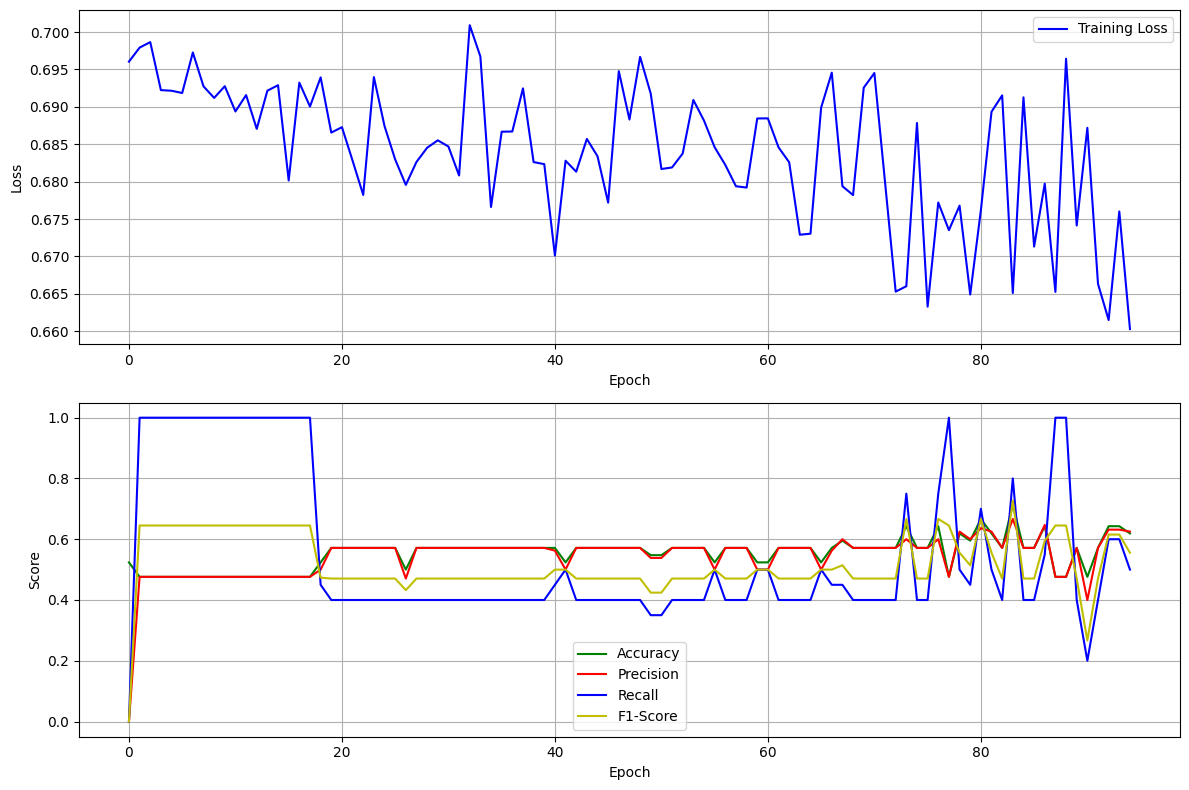

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 096:
Train Loss: 0.6983
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 097:
Train Loss: 0.6517
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 098:
Train Loss: 0.6684
Val Accuracy: 0.5714, Precision: 0.5714, Recall: 0.4000, F1: 0.4706


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 099:
Train Loss: 0.6623
Val Accuracy: 0.5952, Precision: 0.6000, Recall: 0.4500, F1: 0.5143


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 100:
Train Loss: 0.6988
Val Accuracy: 0.5952, Precision: 0.6000, Recall: 0.4500, F1: 0.5143


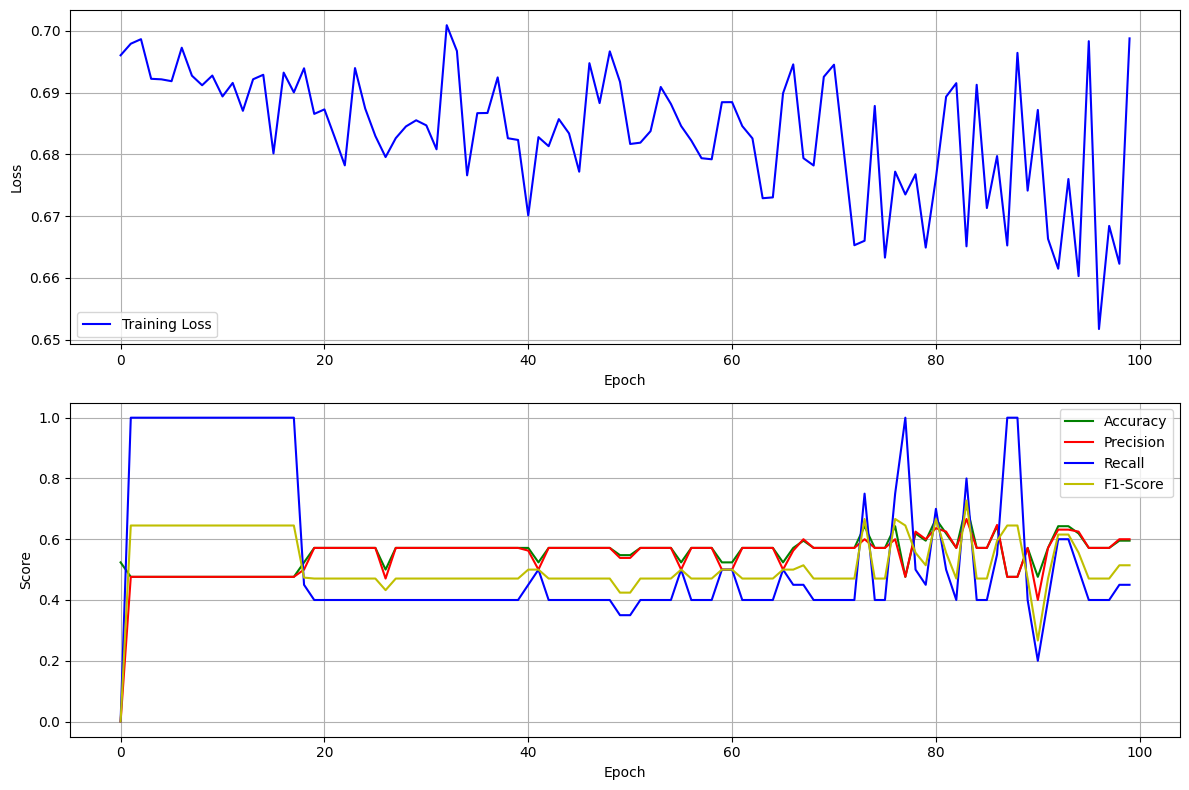

In [7]:
# Training parameters
num_epochs = 100
best_val_acc = 0
train_losses = []
val_metrics = {
    'accuracy': [], 'precision': [], 'recall': [], 'f1': []
}

# Training loop
try:
    for epoch in range(num_epochs):
        # Train
        train_loss = train(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        # Evaluate
        val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, device)
        
        # Store metrics
        val_metrics['accuracy'].append(val_acc)
        val_metrics['precision'].append(val_prec)
        val_metrics['recall'].append(val_rec)
        val_metrics['f1'].append(val_f1)
        
        # Print progress
        print(f'Epoch {epoch+1:03d}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, '
              f'Recall: {val_rec:.4f}, F1: {val_f1:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved! Accuracy: {val_acc:.4f}')
        
        # Plot metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            plot_metrics(train_losses, val_metrics)
            
except Exception as e:
    print(f"Error during training: {str(e)}")
    raise

## Final Evaluation

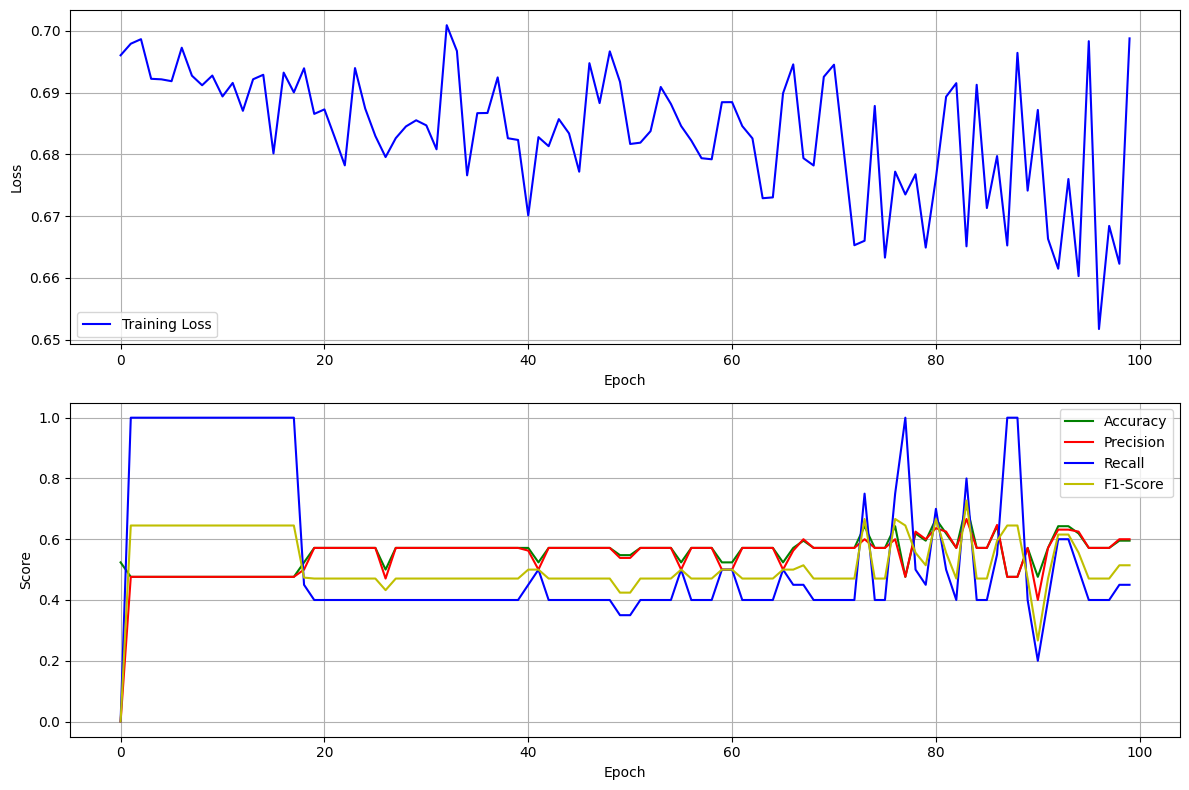

Best validation accuracy: 0.7143


In [8]:
# Plot final training curves
plot_metrics(train_losses, val_metrics)

# Print best validation accuracy
print(f'Best validation accuracy: {best_val_acc:.4f}')